In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

# Iteration 1

### Loading data into pandas and do exploratoin

In [33]:
# load data
test_data = pd.read_csv("/home/yijiaj/FinalData/test.csv")
train_data = pd.read_csv('/home/yijiaj/FinalData/train.csv')
attributes = pd.read_csv("/home/yijiaj/FinalData/attributes.csv")
product_description = pd.read_csv("/home/yijiaj/FinalData/product_descriptions.csv")

In [109]:
print len(test_data)

### Problem statement:
Giving training data contains id, product_uid, product title, and search term, given the relevance as label. We can also used the attributes and product description in the training information, by joining with product_uid. 
Our task is to predict the relevance for data in test set given id and product_uid. 

In [5]:
train_data.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


In [7]:
test_data.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


In [8]:
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90� connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


In [9]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
product_uid    1048485 non-null float64
name           1048485 non-null object
value          1047534 non-null object
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


In [10]:
product_description.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


### Corpus exploration:
For this task, corpus can be seen as the combination of product description which conatins product_uid and product description for this unique product_uid. And the attributes, which contains map of product_uid and name and value. 
To explore the corpus, we can calculate each word's term frequency as well as the invert document frequency in the product description file. Here we can consider each single description as a document in corpus. Also we can seek into the attribut of product and see what relationship the attribut has to the query. 

In [130]:
# terms in product description
terms = dict()
uids = product_description['product_uid']
docs = product_description['product_description']
for i in range(0, len(product_description)):
    terms[uids[i]] = re.split("\W+", docs[i])


#### Calculate Tf and idf of term, score can be represent as tf*idf

In [132]:
# explore prodcut description
# calculate tf and idf for each term in a single product's description.
import re

def calculateTf(uid, t):
#     cur_doc = product_description[product_description['product_uid'] == uid]['product_description'][0]
#     terms = set(re.split("\W+", cur_doc))
    term = terms[uid]
#     tf = dict()
#     for t in term:
#         tf[t] = cur_doc.count(t)
    tf = term.count(t)
    return tf

def calculateIdf(uid, t):
#     cur_doc = product_description[product_description['product_uid'] == uid]['product_description'][0]
#     terms = set(re.split("\W+", cur_doc))
    term = terms[uid]
#     idf = dict()
    N = len(product_description)
#     for t in terms:
#         idf[t] = np.log(N/(getDf(t) + 1))
    idf = np.log(N/(getDf(t) + 1))
    return idf

def getDf(term):
    cnt = 0
    for t in terms.values():
        if term in t:
            cnt += 1
    return cnt

In [71]:
# scores can be represent as tf*idf
def getScore(uid):
    return calculateIdf(uid)*calculateTf(uid)

#### Explore attributes, using information about brands, material, etc

In [75]:
# explore attributes
attributes = attributes[attributes['value'] != 'No']
brands = attributes[attributes['name'] == "MFG Brand Name"]
material = attributes[attributes['name'] == "Material"]

In [76]:
material.head()

,product_uid,name,value
8,100001.0,Material,Galvanized Steel
67,100003.0,Material,Composite
202,100007.0,Material,Plastic
255,100009.0,Material,Medium Density Fiberboard (MDF)
282,100010.0,Material,Steel


In [77]:
brands.head()

,product_uid,name,value
9,100001.0,MFG Brand Name,Simpson Strong-Tie
37,100002.0,MFG Brand Name,BEHR Premium Textured DeckOver
69,100003.0,MFG Brand Name,STERLING
93,100004.0,MFG Brand Name,Grape Solar
122,100005.0,MFG Brand Name,Delta


#### Finding: 
the attributes for each product_uid may be different. For example, some products do not have the informantion about their brand or material. But all the products have product description which we can retrive some information from. Also, the title can also be used to make prediction for relevance. We can see those with related title will more likely to be relevanted. So basically using the decription's tf-idf score, brand, title, material as features and decided whether it is relevant to the query. When processing the description, the data set is very large, we only need to calculate terms appears in search query, but it still cost time to calculate the tf and idf. 

#### Approach to solve the problem:
After deciding which feature to use and feature engineering, we can decide which model to use to make the prediction. Basically machine learning algorithms will be used for prediction. I think for this task, the result is a number in the range of [0, 3], so in this way we can ues regression model as baseline model. For example, we may quantify the feature of the train and test data, use integer to represent str features, and then apply linear regression model to make the prediction. Also, after base line model, I think we can use some model like random forest since RF can handle both classification and regression, and both discrete and continus features work well. So in this way, I may try RF model on the training set and test to see how the model works. Other models like CNN may also be used. And since there are several terms in each query,I pretend to combine them by "OR", "AND", two different operators to make the query, then compare the result's performance. And since we have different field like title and description and attributes, we can try to find different weight for the field and use weight operator like "WAND" to get the relevance.

In [98]:
# Feature engineering
# merge train and test with description
train = train_data.merge(product_description, on = "product_uid", how = 'left')
test = test_data.merge(product_description, on = "product_uid", how = 'left')

In [99]:
train.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [100]:
test.head()

,id,product_uid,product_title,search_term,product_description
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


In [101]:
# merge train and test with brand and material
train = train.merge(brands, on = "product_uid", how = 'left')
test = test.merge(brands, on = "product_uid", how = 'left')
train = train.merge(material,on = "product_uid", how = 'left')
test = test.merge(material, on = "product_uid", how = 'left')

In [102]:
train.head()

,id,product_uid,product_title,search_term,relevance,product_description,name_x,value_x,name_y,value_y
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,MFG Brand Name,BEHR Premium Textured DeckOver,NaN,NaN
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,MFG Brand Name,Delta,NaN,NaN
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,MFG Brand Name,Delta,NaN,NaN


In [104]:
test.head()

,id,product_uid,product_title,search_term,product_description,name_x,value_x,name_y,value_y
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel


### Calculate AND and OR operator's result of each term and save

In [167]:
# calculate AND score, OR score and add new column to train
search_terms = []
for st in train['search_term']:
    search_terms.append(re.split("\W+", st))
AND_score = []
OR_score = []
idx = 0
for ts in search_terms:
    cur_uid = train['product_uid'][idx]
    cur_and = 1 # and , multiply all terms' score
    cur_or = 0 # or, find max one 
    for t in ts:
        cur_tf = calculateTf(cur_uid, t)
        cur_idf = calculateIdf(cur_uid, t)
        cur_and = cur_and * cur_tf*cur_idf
        cur_or = max(cur_or, cur_tf*cur_idf)
    AND_score.append(cur_and)
    OR_score.append(cur_or)
    idx += 1
train['AND_score'] = AND_score
train['OR_score'] = OR_score

In [ ]:
# calculate AND score, OR score and add new column to test
search_terms_t = []
for st in test['search_term']:
    search_terms_t.append(re.split("\W+", st))
AND_score_t = []
OR_score_t = []
idx = 0
for ts in search_terms_t:
    cur_uid = test['product_uid'][idx]
    cur_and = 1 # and , multiply all terms' score
    cur_or = 0 # or, find max one 
    for t in ts:
        cur_tf = calculateTf(cur_uid, t)
        cur_idf = calculateIdf(cur_uid, t)
        cur_and = cur_and * cur_tf*cur_idf
        cur_or = max(cur_or, cur_tf*cur_idf)
    AND_score_t.append(cur_and)
    OR_score_t.append(cur_or)
    idx += 1
test['AND_score'] = AND_score_t
test['OR_score'] = OR_score_t

In [154]:
# process with product title, the percent of terms that appear in title 
train_title = []
test_title = []
idx = 0
for ts in train['search_term']:
    cur_terms = set(re.split("\W+", ts))
    cur_title = set(re.split("\W+", train['product_title'][idx]))
    train_title.append(float(len(cur_terms.intersection(cur_title)))/len(cur_title))
    idx += 1
train['title_contain'] = train_title

In [155]:
idx = 0
for ts in test['search_term']:
    cur_terms = set(re.split("\W+", ts))
    cur_title = set(re.split("\W+", test['product_title'][idx]))
    test_title.append(float(len(cur_terms.intersection(cur_title)))/len(cur_title))
    idx += 1
test['title_contain'] = test_title

In [156]:
train.head()

,id,product_uid,product_title,search_term,relevance,product_description,name_x,value_x,name_y,value_y,score,title_contain
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0,0.0
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0,0.0
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,MFG Brand Name,BEHR Premium Textured DeckOver,NaN,NaN,0,0.0
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,MFG Brand Name,Delta,NaN,NaN,0,0.0
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,MFG Brand Name,Delta,NaN,NaN,0,0.0


In [157]:
test.head()

,id,product_uid,product_title,search_term,product_description,name_x,value_x,name_y,value_y,title_contain
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0.0
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0.0
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0.0
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0.0
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0.0


In [162]:
train.head()

,id,product_uid,product_title,search_term,relevance,product_description,name_x,value_x,name_y,value_y,score,title_contain,AND_score,OR_score
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0,0.0,0.0,0.000000
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ...",MFG Brand Name,Simpson Strong-Tie,Material,Galvanized Steel,0,0.0,0.0,0.000000
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...,MFG Brand Name,BEHR Premium Textured DeckOver,NaN,NaN,0,0.0,0.0,3.713572
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...,MFG Brand Name,Delta,NaN,NaN,0,0.0,0.0,0.000000
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...,MFG Brand Name,Delta,NaN,NaN,0,0.0,0.0,2.397895


#### Findings:
For those with high relevance, OR operator have a higher score than those with low relevance, that means this score can be used as features for prediction. Since AND operator's result requires all terms appears, it is usuallly 0, which means this operator is not a good choice. However, for some relevance which is not that bad, the OR score can also be zero, that means we may use other features and tune their weight in order to get a better result. Using tf-idf socre based on description only will not be a good choice. 

### Next steps:
Features: improved feature engineering

Baseline model: linear regression - using spark mllib

Imporved ML model: Random forest - regression and classification, using spark mllib

# Iteration 2

### Improved feature engineering
Since only using tf-idf score will result in a slow processing time, there are other features that can be used. The featues choosing are: overlap of query terms and description overlap of query terms and title, attributes, length of query terms, and remove stop words. Since spark will cause gc memory problems, here I use pandas and other libs to do the feature extraction and preprocessing. Then save the file and processing by spark pipeline.

### Features with description

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

In [2]:
stemmer = SnowballStemmer('english')

In [3]:
# tokenize and stem 
# reference: http://stackoverflow.com/questions/13964045/ntlk-python-frenchstemmer
def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

In [4]:
# load data
# reference: http://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
test_data = pd.read_csv("/home/yijiaj/FinalData/test.csv",encoding="ISO-8859-1")
train_data = pd.read_csv('/home/yijiaj/FinalData/train.csv',encoding="ISO-8859-1")
attributes = pd.read_csv("/home/yijiaj/FinalData/attributes.csv")
product_description = pd.read_csv("/home/yijiaj/FinalData/product_descriptions.csv")

In [5]:
train_data['search_term'] = train_data['search_term'].map(lambda x:str_stemmer(x))

In [6]:
test_data['search_term'] = test_data['search_term'].map(lambda x:str_stemmer(x))

In [7]:
train_data['product_title'] = train_data['product_title'].map(lambda x:str_stemmer(x))

In [8]:
test_data['product_title'] = test_data['product_title'].map(lambda x:str_stemmer(x))

In [9]:
train_data.head(2)

,id,product_uid,product_title,search_term,relevance
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.0
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.5


In [10]:
train = pd.merge(train_data, product_description, how='left', on='product_uid')

In [11]:
test = pd.merge(test_data, product_description, how='left', on='product_uid')

In [12]:
test.head(2)

,id,product_uid,product_title,search_term,product_description
0,1,100001,simpson strong-ti 12-gaug angl,90 degre bracket,"Not only do angles make joints stronger, they ..."
1,4,100001,simpson strong-ti 12-gaug angl,metal l bracket,"Not only do angles make joints stronger, they ..."


In [13]:
train['product_description'] = train['product_description'].map(lambda x:str_stemmer(x))

In [22]:
test['product_description'] = test['product_description'].map(lambda x:str_stemmer(x))

In [14]:
# length of the query
train['query_len'] = train['search_term'].map(lambda x:len(x.split())).astype(np.int64)

In [15]:
test['query_len'] = test['search_term'].map(lambda x:len(x.split())).astype(np.int64)

In [16]:
train.head(2)

,id,product_uid,product_title,search_term,relevance,product_description,query_len
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.0,"not onli do angl make joint stronger, they als...",2
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.5,"not onli do angl make joint stronger, they als...",2


In [17]:
# commen words calculation
def common(s1, s2):
    return sum(int(s2.find(word)>=0) for word in s1.split())

In [18]:
train['info'] = train['search_term']+"\t"+train['product_title']+"\t"+train['product_description']

In [19]:
test['info'] = test['search_term']+"\t"+test['product_title']+"\t"+test['product_description']

In [20]:
train['common_title'] = train['info'].map(lambda x:common(x.split('\t')[0],x.split('\t')[1]))
train['common_descriptoin'] = train['info'].map(lambda x:common(x.split('\t')[0],x.split('\t')[2]))

In [21]:
train.head(2)

,id,product_uid,product_title,search_term,relevance,product_description,query_len,info,common_title,common_descriptoin
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.0,"not onli do angl make joint stronger, they als...",2,angl bracket\tsimpson strong-ti 12-gaug angl\t...,1,1
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.5,"not onli do angl make joint stronger, they als...",2,l bracket\tsimpson strong-ti 12-gaug angl\tnot...,1,1


In [22]:
test['common_title'] = test['info'].map(lambda x:common(x.split('\t')[0],x.split('\t')[1]))
test['common_descriptoin'] = test['info'].map(lambda x:common(x.split('\t')[0],x.split('\t')[2]))
test.head(2)

,id,product_uid,product_title,search_term,product_description,query_len,info,common_title,common_descriptoin
0,1,100001,simpson strong-ti 12-gaug angl,90 degre bracket,"Not only do angles make joints stronger, they ...",3,90 degre bracket\tsimpson strong-ti 12-gaug an...,0,1
1,4,100001,simpson strong-ti 12-gaug angl,metal l bracket,"Not only do angles make joints stronger, they ...",3,metal l bracket\tsimpson strong-ti 12-gaug ang...,1,1


From description, we can get the overlap terms number of query and title, and overlap terms number of description and query, we also get query's length. These features can be the features we use. Then we will try to deplore attributes, to see what we can find. 

### Features with attribute

As we can observed, there are lots of name and value in attribute, and for each product, the name and value may be differnet. So we can try to find whether a name and value value contains query. If it contains the terms in query, it may be relevance.

In [22]:
attributes = pd.read_csv("/home/yijiaj/FinalData/attributes.csv")
attributes.head(3)

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90� connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...


In [23]:
# merge attribute to find terms in query
# reference: https://www.kaggle.com/junfeng/home-depot-product-search-relevance/sklearn-random-forest-merge-attributes
def merge(attr):
    names = attr["name"]
    values = attr["value"]
    merge = []
    for name, value in zip(names, values):
        merge.append(" ".join((name, value)))
    return " ".join(merge)

In [24]:
attributes.dropna(how="all", inplace=True)
attributes["product_uid"] = attributes["product_uid"].astype(int)
attributes["value"] = attributes["value"].astype(str)
product_attributes = attributes.groupby("product_uid").apply(merge)
product_attributes = product_attributes.reset_index(name="product_attributes")

In [25]:
train = pd.merge(train, product_attributes, how="left", on="product_uid")

In [26]:
train.head(3)

,id,product_uid,product_title,search_term,relevance,product_description,query_len,info,common_title,common_descriptoin,product_attributes
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.0,"not onli do angl make joint stronger, they als...",2,angl bracket\tsimpson strong-ti 12-gaug angl\t...,1,1,Bullet01 Versatile connector for various 90� c...
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.5,"not onli do angl make joint stronger, they als...",2,l bracket\tsimpson strong-ti 12-gaug angl\tnot...,1,1,Bullet01 Versatile connector for various 90� c...
2,9,100002,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,3.0,behr premium textur deckov is an innov solid c...,2,deck over\tbehr premium textur deckov 1-gal. #...,1,1,"Application Method Brush,Roller,Spray Assemble..."


In [28]:
train['product_attributes_x'] = train['product_attributes'].fillna('')

In [ ]:
train['info_attr'] = train['search_term']+"\t"+train['product_attributes']
train['common_attributes'] = train['info_attr'].map(lambda x:common(x.split('\t')[0],x.split('\t')[1]))

In [53]:
train = train.drop(['search_term','product_title','product_description','description_title', 'product_attributes', 'info', 'info_attr', ],axis=1)

In [46]:
test = pd.merge(test, product_attributes, how="left", on="product_uid")
test['product_attributes'] = test['product_attributes'].fillna('')
test['info_attr'] = test['search_term']+"\t"+test['product_attributes']
test['common_attributes'] = test['info_attr'].map(lambda x:common(x.split('\t')[0],x.split('\t')[1]))
test = test.drop(['search_term','product_title','product_description','description_title', 'product_attributes', 'info', 'info_attr', ],axis=1)
test.head(3)

,id,product_uid,query_len,common_title,common_descriptoin,common_attributes
0,1,100001,3,0,1,1
1,4,100001,3,1,1,1
2,5,100001,3,0,0,0


In [55]:
train = train.drop(['search_term','product_title','product_description','description_title', 'product_attributes_x', 'info', ],axis=1)

After extracting features from attributes, we have 4 features and then we can use these features to train the model and do the prediction. First we save the data into csv file.

In [55]:
train.to_csv('/home/yijiaj/FinalData/train_feature.csv')

In [47]:
test.to_csv('/home/yijiaj/FinalData/test_feature.csv')

In [23]:
train.head(2)

,id,product_uid,product_title,search_term,relevance,product_description,query_len,info,common_title,common_descriptoin
0,2,100001,simpson strong-ti 12-gaug angl,angl bracket,3.0,"Not only do angles make joints stronger, they ...",2,angl bracket\tsimpson strong-ti 12-gaug angl\t...,1,1
1,3,100001,simpson strong-ti 12-gaug angl,l bracket,2.5,"Not only do angles make joints stronger, they ...",2,l bracket\tsimpson strong-ti 12-gaug angl\tNot...,1,1


In [24]:
test.head(2)

,id,product_uid,product_title,search_term,product_description,query_len,info,common_title,common_descriptoin
0,1,100001,simpson strong-ti 12-gaug angl,90 degre bracket,"Not only do angles make joints stronger, they ...",3,90 degre bracket\tsimpson strong-ti 12-gaug an...,0,1
1,4,100001,simpson strong-ti 12-gaug angl,metal l bracket,"Not only do angles make joints stronger, they ...",3,metal l bracket\tsimpson strong-ti 12-gaug ang...,1,1


In [25]:
train = train.drop(['search_term','product_title','product_description', 'info', 'product_uid'],axis=1)
test = test.drop(['search_term','product_title','product_description', 'info', 'product_uid'],axis=1)

In [27]:
train.to_csv('/home/yijiaj/FinalData/train_feature_base.csv')
test.to_csv('/home/yijiaj/FinalData/test_feature_base.csv')

### Using spark

In [2]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark import SparkContext
from pyspark.sql import SparkSession
# create SparkContext if sc doesn't exist.
try:
    sc
except NameError:
    sc =SparkContext()
from pyspark.sql import SparkSession
from pyspark.ml.feature import IndexToString, StringIndexer
from pyspark.ml import Pipeline 
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml.linalg import Vectors 
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.regression import RandomForestRegressor 
from pyspark.ml.feature import VectorIndexer 
from pyspark.ml.evaluation import RegressionEvaluator 
import os

In [3]:
spark = SparkSession.builder.appName("FinalPrj").getOrCreate()

In [30]:
df = spark.read.csv("/home/yijiaj/FinalData/train_feature_base.csv",header=True,inferSchema=True)

In [31]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [32]:
df.take(1)

[Row(_c0=0, id=2, relevance=3.0, query_len=2, common_title=1, common_descriptoin=1)]

In [33]:
trainingData.take(1)

[Row(_c0=1, id=3, relevance=2.5, query_len=2, common_title=1, common_descriptoin=1)]

### ML models for prediction
In this part, I will try to use some ML models to find the relevance of test data. For this task, give information about query and products, this can be done with linear regression and random forest. So I try to use this two model to see the prediction result. To validate the model's performance, split the data to training set and validation set. Train the model on the training set and test on validation set to have a rough evluatoin on the model.

### Linear regression model

In [34]:
# reference: https://spark.apache.org/docs/2.1.0/ml-classification-regression.html
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.linalg import SparseVector
from pyspark.sql.functions import udf
vs = VectorAssembler(inputCols=["query_len", "common_title", "common_descriptoin"],outputCol='features')
train_lr = vs.transform(trainingData)

In [35]:
train_lr.count()

52008

In [36]:
lr = LinearRegression(featuresCol='features', regParam=0.3, elasticNetParam=0.8,labelCol='relevance',maxIter=1000)
model = lr.fit(train_lr)

In [37]:
lr_summary = model.summary

In [38]:
print("Coefficients: %s" % str(model.coefficients))
print("Intercept: %s" % str(model.intercept))
print("numIterations: %d" % lr_summary.totalIterations)
print("objectiveHistory: %s" % str(lr_summary.objectiveHistory))
print("RMSE: %f" % lr_summary.rootMeanSquaredError)
print("r2: %f" % lr_summary.r2)

Coefficients: [0.0,0.0,0.0]
Intercept: 2.38308183356
numIterations: 1
objectiveHistory: [0.4999999999999982]
RMSE: 0.532199
r2: 0.000000


In [39]:
test_lr = vs.transform(testData)
predict_lr = model.transform(test_lr)

In [40]:
predict_lr.show(5)

+---+---+---------+---------+------------+------------------+-------------+-----------------+
|_c0| id|relevance|query_len|common_title|common_descriptoin|     features|       prediction|
+---+---+---------+---------+------------+------------------+-------------+-----------------+
|  0|  2|      3.0|        2|           1|                 1|[2.0,1.0,1.0]|2.383081833564015|
|  4| 17|     2.67|        3|           3|                 0|[3.0,3.0,0.0]|2.383081833564015|
|  5| 18|      3.0|        2|           1|                 1|[2.0,1.0,1.0]|2.383081833564015|
|  7| 21|      3.0|        1|           1|                 1|[1.0,1.0,1.0]|2.383081833564015|
| 16| 65|      3.0|        2|           2|                 2|[2.0,2.0,2.0]|2.383081833564015|
+---+---+---------+---------+------------+------------------+-------------+-----------------+
only showing top 5 rows



#### Evluate linear regression model

In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="relevance", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predict_lr)
print("Root Mean Squared Error (RMSE) on validation data = %g" % rmse)

Root Mean Squared Error (RMSE) on validation data = 0.538163


### Random forest model

In [42]:
# reference: https://spark.apache.org/docs/1.6.2/ml-classification-regression.html
rf = RandomForestRegressor(featuresCol="features")

In [43]:
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(train_lr)
labelIndexer = StringIndexer(inputCol="relevance", outputCol="label").fit(train_lr)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])
model = pipeline.fit(train_lr)
predict_rf = model.transform(test_lr)

In [46]:
train_lr.show(5)

+---+---+---------+---------+------------+------------------+-------------+
|_c0| id|relevance|query_len|common_title|common_descriptoin|     features|
+---+---+---------+---------+------------+------------------+-------------+
|  1|  3|      2.5|        2|           1|                 1|[2.0,1.0,1.0]|
|  2|  9|      3.0|        2|           1|                 2|[2.0,1.0,2.0]|
|  3| 16|     2.33|        3|           1|                 0|[3.0,1.0,0.0]|
|  6| 20|     2.67|        3|           2|                 2|[3.0,2.0,2.0]|
|  8| 23|     2.67|        2|           2|                 1|[2.0,2.0,1.0]|
+---+---+---------+---------+------------+------------------+-------------+
only showing top 5 rows



In [47]:
predict_rf.show(5)

+---+---+---------+---------+------------+------------------+-------------+-----+---------------+------------------+
|_c0| id|relevance|query_len|common_title|common_descriptoin|     features|label|indexedFeatures|        prediction|
+---+---+---------+---------+------------+------------------+-------------+-----+---------------+------------------+
|  0|  2|      3.0|        2|           1|                 1|[2.0,1.0,1.0]|  0.0|  [1.0,1.0,1.0]|1.6124503636927687|
|  4| 17|     2.67|        3|           3|                 0|[3.0,3.0,0.0]|  2.0|  [2.0,3.0,0.0]|1.5116851971044116|
|  5| 18|      3.0|        2|           1|                 1|[2.0,1.0,1.0]|  0.0|  [1.0,1.0,1.0]|1.6124503636927687|
|  7| 21|      3.0|        1|           1|                 1|[1.0,1.0,1.0]|  0.0|  [0.0,1.0,1.0]|1.7349047826815904|
| 16| 65|      3.0|        2|           2|                 2|[2.0,2.0,2.0]|  0.0|  [1.0,2.0,2.0]|1.2592746451497339|
+---+---+---------+---------+------------+------------------+---

In [48]:
# evluator for regression 
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predict_rf)
print("Root Mean Squared Error = %g" % rmse)

Root Mean Squared Error = 1.53628


In [49]:
# Mean Squared Error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predict_rf)
print("Mean Squared Error = %g" % mse)

Mean Squared Error = 2.36016


In [50]:
# R^2 metric
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predict_rf)
print("R^2 metric = %g" % r2)

R^2 metric = 0.116184


In [51]:
# Mean Absolute Error 
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predict_rf)
print("Mean Absolute Error  = %g" % mae)

Mean Absolute Error  = 1.26741


Here we use two regression model to train on training data and test on validation set. From the result we can see that the result of random forest is better than linear regression. Then we can try on the test data data and seet the result of two methods. 

## Get results on test data

In [52]:
df_test = spark.read.csv("/home/yijiaj/FinalData/test_feature_base.csv",header=True,inferSchema=True)

In [53]:
df_test.count()

166693

In [57]:
df.show(3)

+---+---+---------+---------+------------+------------------+
|_c0| id|relevance|query_len|common_title|common_descriptoin|
+---+---+---------+---------+------------+------------------+
|  0|  2|      3.0|        2|           1|                 1|
|  1|  3|      2.5|        2|           1|                 1|
|  2|  9|      3.0|        2|           1|                 2|
+---+---+---------+---------+------------+------------------+
only showing top 3 rows



In [58]:
df_train = vs.transform(df)

### Linear regression

In [59]:
lr = LinearRegression(featuresCol='features', regParam=0.3, elasticNetParam=0.8,labelCol='relevance',maxIter=1000)
model_lr = lr.fit(df_train)
test = vs.transform(df_test)
predict_linear = model_lr.transform(test)

### Random forest model

In [60]:
model_rf = pipeline.fit(df_train)
predict_random = model.transform(test)

In [61]:
predict_random.count()

166693

In [62]:
lr_res = predict_linear.select("id", "prediction")

In [63]:
lr_res.take(2)

[Row(id=1, prediction=2.381633791027016),
 Row(id=4, prediction=2.381633791027016)]

In [64]:
lr_res.count()

166693

In [65]:
rf_res = predict_random.select("id", "prediction")

In [66]:
rf_res.take(2)

[Row(id=1, prediction=2.479016125702889),
 Row(id=4, prediction=2.1666405892425566)]

In [67]:
p_lr = predict_linear
p_lr = p_lr.drop("_c0", "product_uid","query_len","common_title", "common_descriptoin", "common_attributes", "features")

In [68]:
p_rf = predict_random
p_rf = p_rf.drop("_c0", "product_uid","query_len","common_title", "common_descriptoin", "common_attributes","indexedFeatures", "features")

In [69]:
p_rf.toPandas().to_csv("/home/yijiaj/FinalData/predict_random_base.csv",index=False)

In [70]:
p_lr.toPandas().to_csv("/home/yijiaj/FinalData/predict_linear_base.csv",index=False)

### Result
After submitting on kaggle, both random forest and linear regression have a score about 0.5. That means the feature shold be considered carefully and there may be some adjustments to improvement the performance. The next step is working on features and models to see how to make some improvment. 

Baseline of linear regression:
![linear_res](https://raw.githubusercontent.com/YijiaJin/Plot/master/linear.png)

# Iteration 3

Since the result from is not very good, about 0.53 for linear regression and 0.6 for random forest, improved feature engineering shuold be though over throuhg the orgional data set. More careful data exploration should be done about the input data. 

## Improved feature engineering

In [32]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

### Visualize on data set

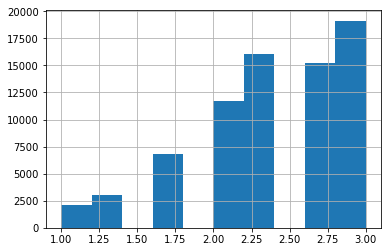

In [33]:
plt.figure()
train_data['relevance'].hist()

From the plot, we can see that most of the result is from 2.0 to 3.0. So it may happens that, the data in training set is mostly have a label between 2.0 to 3.0, so that our prediction, will also have a possbility in this range. 

In [34]:
train_feature = pd.read_csv("/home/yijiaj/FinalData/train_feature.csv")

Load train feauter extract from iteration2, and plot scatter to see whethe these features are useful for our task.

In [35]:
train_feature.head()

,Unnamed: 0,id,product_uid,relevance,query_len,common_title,common_descriptoin,common_attributes
0,0,2,100001,3.00,2,0,1,1
1,1,3,100001,2.50,2,1,1,1
2,2,9,100002,3.00,2,0,2,2
3,3,16,100005,2.33,3,0,0,2
4,4,17,100005,2.67,3,0,0,1


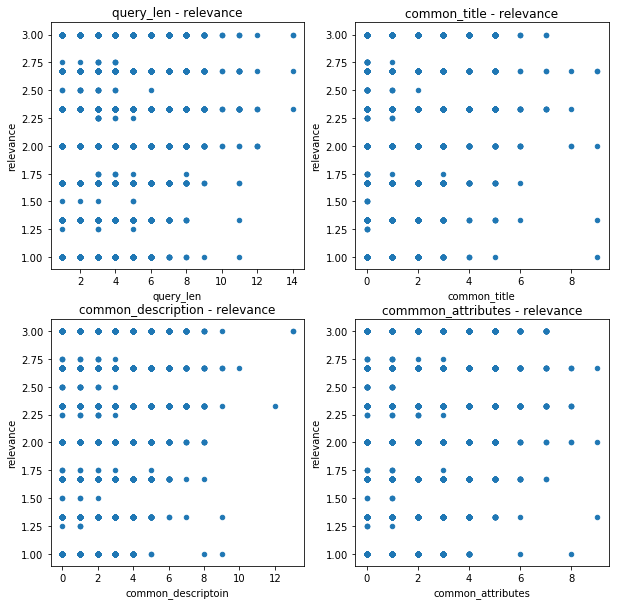

In [38]:
# without stem, four features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
train_feature.plot(ax=axes[0,0], x='query_len', y='relevance', kind='scatter')
axes[0,0].set_title('query_len - relevance')

train_feature.plot(ax=axes[0,1], x='common_title', y='relevance', kind='scatter')
axes[0,1].set_title('common_title - relevance')

train_feature.plot(ax=axes[1,0], x='common_descriptoin', y='relevance', kind='scatter')
axes[1,0].set_title('common_description - relevance')

train_feature.plot(ax=axes[1,1], x='common_attributes', y='relevance', kind='scatter')
axes[1,1].set_title('commmon_attributes - relevance')
plt.show()

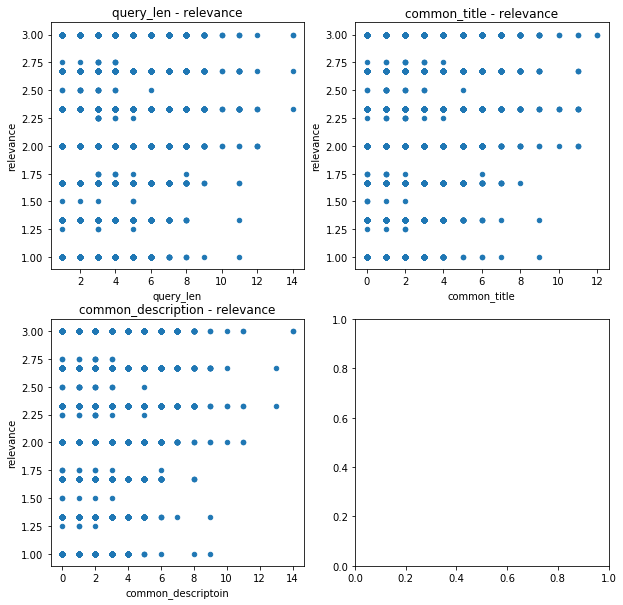

In [44]:
# with stem, three features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
train.plot(ax=axes[0,0], x='query_len', y='relevance', kind='scatter')
axes[0,0].set_title('query_len - relevance')

train.plot(ax=axes[0,1], x='common_title', y='relevance', kind='scatter')
axes[0,1].set_title('common_title - relevance')

train.plot(ax=axes[1,0], x='common_descriptoin', y='relevance', kind='scatter')
axes[1,0].set_title('common_description - relevance')

plt.show()

From the plot, we can see that there is no linear relationship between these features and relevance. So that can explain why linear's performance is about 0.53, which is not a very good one. So I try to use other information in attributes so that we may get a better result. Actually, if we try to predict each item's relevance for the mean of all relevance, the reuslt is about 0.53. So the performance of a worked model should be better than that.

In [42]:
attributes = pd.read_csv("/home/yijiaj/FinalData/attributes.csv")
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90� connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


Then I think that the input query may have some misspelled words and some stop words from the query and description from the input data source. I tried stem the input data but the result shows that stem does not have many improvemenet in performance, so maybe removing stop words and correct input typo should come first. To fix typo, using existed powerful like google would be a good idea. 

In [2]:
# refernce: chirayukong.github.io
import requests
import re
import time
from random import randint

START_SPELL_CHECK="<span class=\"spell\">Showing results for</span>"
END_SPELL_CHECK="<br><span class=\"spell_orig\">Search instead for"

HTML_Codes = (
    ("'", '&#39;'),
    ('"', '&quot;'),
    ('>', '&gt;'),
    ('<', '&lt;'),
    ('&', '&amp;'),
)

def spell_check(s):
    q = '+'.join(s.split())
    r = requests.get("https://www.google.co.uk/search?q="+q)
    content = r.text
    start=content.find(START_SPELL_CHECK) 
    if ( start > -1 ):
        start = start + len(START_SPELL_CHECK)
        end=content.find(END_SPELL_CHECK)
        search= content[start:end]
        search = re.sub(r'<[^>]+>', '', search)
        for code in HTML_Codes:
            search = search.replace(code[1], code[0])
        search = search[1:]
    else:
        search = s
    return search ;

In [3]:
train3 = pd.read_csv("/home/yijiaj/FinalData/train.csv")

In [ ]:
train3['search_term'] = train3['search_term'].map(lambda x:spell_check(x))

The experiments show that using google to remove typo requires a lot of time. And experiments show that even without removing typos, the result can still be a good one, so I do not use this metric in final round. Linear regression is considered as a bad way for this task, since the features show no linear relationship to the label, and the result is just like the mean of all labels. So only consider random forest model here. 

### Random Forest in Spark 

#### 1. Three features with stem

In [29]:
df_train = spark.read.csv("/home/yijiaj/FinalData/def_train.csv",header=True,inferSchema=True)
df_test = spark.read.csv('/home/yijiaj/FinalData/def_test.csv',header=True,inferSchema=True)

In [30]:
df_train.show(4)

+---+---+-----------+---------+------------+-------------+-------------------+
|_c0| id|product_uid|relevance|len_of_query|word_in_title|word_in_description|
+---+---+-----------+---------+------------+-------------+-------------------+
|  0|  2|     100001|      3.0|           2|            1|                  1|
|  1|  3|     100001|      2.5|           2|            1|                  1|
|  2|  9|     100002|      3.0|           2|            1|                  1|
|  3| 16|     100005|     2.33|           3|            1|                  1|
+---+---+-----------+---------+------------+-------------+-------------------+
only showing top 4 rows



In [31]:
vs = VectorAssembler(inputCols=["len_of_query", "word_in_title", "word_in_description"],outputCol='features')
train_lr = vs.transform(df_train)

In [32]:
from pyspark.ml.regression import RandomForestRegressor 
rf = RandomForestRegressor(featuresCol="features",numTrees=15, maxDepth=6, seed=0, labelCol="relevance")

In [8]:
modle1 = rf.fit(train_lr)

In [9]:
df_test.show(3)

+-----+---+-----------+---------+------------+-------------+-------------------+
|  _c0| id|product_uid|relevance|len_of_query|word_in_title|word_in_description|
+-----+---+-----------+---------+------------+-------------+-------------------+
|74067|  1|     100001|     null|           3|            0|                  1|
|74068|  4|     100001|     null|           3|            1|                  1|
|74069|  5|     100001|     null|           3|            1|                  1|
+-----+---+-----------+---------+------------+-------------+-------------------+
only showing top 3 rows



In [10]:
test_lr = vs.transform(df_test)

In [12]:
rf_pred = modle1.transform(test_lr)

In [13]:
selected = rf_pred.select("id", "prediction")
selected.toPandas().to_csv('/home/yijiaj/FinalData/rf_pred_spark.csv')

Result:
![res1](https://raw.githubusercontent.com/YijiaJin/Plot/master/res1.png)

We can see that this result is a good one compared to linear regression's 0.53.

#### Tune parameters with ParamGridBuilder
The parameters are very important for models. Spark ParamGridBuilder gives a convenient way to find the optimal parameters and do cross valiation. Now I will using ParamGridBuilder to see if this can give some improvment to the performance. 

In [94]:
(trainingData, testData) = df_train.randomSplit([0.7, 0.3])

In [95]:
trainingData.show(3)

+---+---+-----------+---------+------------+-------------+-------------------+
|_c0| id|product_uid|relevance|len_of_query|word_in_title|word_in_description|
+---+---+-----------+---------+------------+-------------+-------------------+
|  1|  3|     100001|      2.5|           2|            1|                  1|
|  2|  9|     100002|      3.0|           2|            1|                  1|
|  3| 16|     100005|     2.33|           3|            1|                  1|
+---+---+-----------+---------+------------+-------------+-------------------+
only showing top 3 rows



In [96]:
rf = RandomForestRegressor(featuresCol="features",numTrees=15, maxDepth=6, seed=0,labelCol="label")
labelIndexer = StringIndexer(inputCol="relevance", outputCol="label")

In [104]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
pipeline = Pipeline(stages=[vs,labelIndexer, rf])
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [6]).addGrid(rf.numTrees, [15]).build()

In [105]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2)

In [106]:
cvModel = crossval.fit(df_train)

In [107]:
prediction1_pip = cvModel.transform(testData)

In [108]:
# evluator for regression 
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction1_pip)
print("Root Mean Squared Error = %g" % rmse)

Root Mean Squared Error = 1.51639


In [84]:
selected = prediction1_pip.select("id", "prediction")

In [109]:
select = selected.toPandas()

In [110]:
# label should be in [1, 3]
def filt(num):
    if num < 1:
        num = 1
    if num > 3:
        num = 3
    return num

In [111]:
select['prediction'] = select['prediction'].map(lambda x: filt(x))

In [112]:
select.to_csv('/home/yijiaj/FinalData/rf_pred_pip1.csv')

Result:
![pip](https://raw.githubusercontent.com/YijiaJin/Plot/master/pip.png)

The result is weird, I have tried several parameters to included in ParamGridBuilder, but the more parameters were added, the worse the performance would be. Even though I included the previous value in the range, the performance will not be as good as origional one. It seems that origional one is good enough.

### 2.  Four features without stem

In [4]:
df_train = spark.read.csv("/home/yijiaj/FinalData/train_feature.csv",header=True,inferSchema=True)
df_test = spark.read.csv('/home/yijiaj/FinalData/test_feature.csv',header=True,inferSchema=True)

In [15]:
df_train.show(4)

+---+---+-----------+---------+---------+------------+------------------+-----------------+
|_c0| id|product_uid|relevance|query_len|common_title|common_descriptoin|common_attributes|
+---+---+-----------+---------+---------+------------+------------------+-----------------+
|  0|  2|     100001|      3.0|        2|           0|                 1|                1|
|  1|  3|     100001|      2.5|        2|           1|                 1|                1|
|  2|  9|     100002|      3.0|        2|           0|                 2|                2|
|  3| 16|     100005|     2.33|        3|           0|                 0|                2|
+---+---+-----------+---------+---------+------------+------------------+-----------------+
only showing top 4 rows



In [5]:
vs = VectorAssembler(inputCols=["query_len", "common_title", "common_descriptoin", "common_attributes"],outputCol='features')
train_lr = vs.transform(df_train)

In [17]:
test_lr = vs.transform(df_test)

In [21]:
test_lr.show(3)

+---+---+-----------+---------+------------+------------------+-----------------+-----------------+
|_c0| id|product_uid|query_len|common_title|common_descriptoin|common_attributes|         features|
+---+---+-----------+---------+------------+------------------+-----------------+-----------------+
|  0|  1|     100001|        3|           0|                 1|                1|[3.0,0.0,1.0,1.0]|
|  1|  4|     100001|        3|           1|                 1|                1|[3.0,1.0,1.0,1.0]|
|  2|  5|     100001|        3|           0|                 0|                0|    (4,[0],[3.0])|
+---+---+-----------+---------+------------+------------------+-----------------+-----------------+
only showing top 3 rows



In [18]:
modle2 = rf.fit(train_lr)

In [20]:
rf_pred = modle2.transform(test_lr)

In [22]:
selected = rf_pred.select("id", "prediction")
selected.toPandas().to_csv('/home/yijiaj/FinalData/rf_pred_spark2.csv')

Result:
![res2](https://raw.githubusercontent.com/YijiaJin/Plot/master/res2.png)   

This result is worse than res1, which use stem, even with less featuers. So wee can see that stem is a useful way for processing data. And sometimes more features may not guarantee a good performance. But still, this is better than linear regression.

#### Tune parameters with ParamGridBuilder
The parameters are very important for models. Spark ParamGridBuilder gives a convenient way to find the optimal parameters and do cross valiation. Now I will using ParamGridBuilder to see if this can give some improvment to the performance. 

In [6]:
rf = RandomForestRegressor(featuresCol="features",numTrees=15, maxDepth=6, seed=0,labelCol="label")
labelIndexer = StringIndexer(inputCol="relevance", outputCol="label")

In [7]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
pipeline = Pipeline(stages=[vs,labelIndexer, rf])
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [3,7]).addGrid(rf.numTrees, [12,16]).build()

In [8]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2)

In [9]:
cvModel = crossval.fit(df_train)

In [10]:
prediction2_pip = cvModel.transform(df_test)

In [12]:
selected = prediction2_pip.select("id", "prediction")

In [13]:
select = selected.toPandas()
# label should be in [1, 3]
def filt(num):
    if num < 1:
        num = 1
    if num > 3:
        num = 3
    return num

In [14]:
select['prediction'] = select['prediction'].map(lambda x: filt(x))
select.to_csv('/home/yijiaj/FinalData/rf_pred_pip2.csv')

Result:
![p2](https://raw.githubusercontent.com/YijiaJin/Plot/master/pip2.png)    

The result is worse than without paramGridBuilder, but better than previous ParamGridBuilder. Weird. Tried but did not figure out what happened.

## Result an Conclusion

From the result, we can see that with only three featues: term frequency in title, term frequency in description, term number in query and with stem prepossing, the regression random forest model get the best result, with a rmse = 0.49. In this task, spark and pandas ML libs is used to do the feature engineering and data prepossing. Some prepossing like remove stop words and remove typo seems not necessary for this task. 

In this task, I learned more about pyspark and pandas, pipline and paramGridBuilder. Sometimes we may not get expected result for the model, but the important thing is the idea to solve the problems and to analyse the problems. 
There are many problems I have met, like storage overflow in spark, linear regression weird result in spark, data missing and typos in raw data, paramGridBuilder not giving better performance in spark. To solve these problems, some official documents is very useful, and some previous people's experience is also useful. I tried to change the default set in spark, adding new ways in featuer engineering, more ways for prepossing, and changing parameters one by one. My experience is if some problems happen, first try to figure out which part makes things crush down, and then try to fix it. 

What can be done more about this task is to seek deep into the attribute, when I add attribute's information, I get no improvment in performance, that might because i didn't analyse much about the attributes. The attributes contain many information, it needs deep exploration to figure out which one is useful and how to deal with the missing data in order not to cause overfit or bias. More future work can be done about this. Thanks!